## Health Survey Risk Factors
source: https://www.kaggle.com/datasets/lplenka/brfss-data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import tree


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier,RUSBoostClassifier,EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso,Ridge,ElasticNet
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB  # Naive Bayes classifiers
from scipy.stats import chi2_contingency,f_oneway
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree   # Decision tree


In [71]:
df=pd.read_csv('/Users/aliceqichaowu/Desktop/38615/FinalProject/brfss2013/brfss2013_new1.csv',low_memory=False)
df.head()


,genhlth,physhlth,menthlth,hlthpln1,persdoc2,medcost,checkup1,sleptim1,bphigh4,bloodcho,...,fc60_,strfreq_,pamiss1_,X_pastrng,X_lmtact1,X_lmtwrk1,X_lmtscl1,X_rfseat2,X_rfseat3,X_age80
0,Good,0.0,0.0,Yes,"Yes, only one",No,Within past year,6.0,No,Yes,...,506.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,50.0
1,Good,3.0,2.0,Yes,"Yes, only one",No,Within past year,9.0,No,Yes,...,474.0,0.0,0.0,Did not meet muscle strengthening recommendations,Told have arthritis and have limited usual act...,Told have arthritis and have limited work,Told have arthritis and social activities limi...,Always or almost always wear seat belt,Always wear seat belt,55.0
2,Very good,2.0,0.0,Yes,"Yes, only one",No,Within past 2 years,8.0,No,Yes,...,417.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,64.0
3,Good,10.0,2.0,Yes,"Yes, only one",No,5 or more years ago,6.0,Yes,Yes,...,406.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,66.0
4,Very good,0.0,0.0,Yes,"Yes, only one",No,Within past year,8.0,Yes,Yes,...,512.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,49.0


## Preprocessing


In [ ]:
## Check missing values
# print('There are %i nan in the dataframe' % df.isna().sum().sum())
df.isnull().sum()/df.shape[0]

In [ ]:
## find out how many columns have missing values < 10% data pts for each column
## 0.1: 0.69; 0.15: 0.491; 0.2: 0.42;
mask=df.isnull().sum()/df.shape[0]<0.1
features=df.columns[mask]
df1=df[features]
print('Percentage of columns remained: ', len(features)/len(df.columns))

In [ ]:
rows_remain=len(df1[df1.isnull().any(axis=1)])/len(df1)
print('Percentage of rows remained after removing missing values: ',rows_remain )

In [ ]:
df1.dropna(inplace=True)
df1.reset_index(drop=True,inplace=True)

In [ ]:
## drop useless columns
df=df.drop(columns=['X_misfrtn','X_misvegn','X_frtresp','X_vegresp'])

## EDA

In [72]:
features = pd.read_csv('/Users/aliceqichaowu/Desktop/38615/FinalProject/features.txt', sep=' ',header=None)
feat_lst=features.iloc[:,0].values.tolist()

In [73]:
## transform categorical 
df_cat=df.select_dtypes(include='object')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num=df.select_dtypes(include=numerics)
df_cat['genhlth'].replace(['Excellent','Very good','Good','Fair','Poor'],
                        [1,2,3,4,5], inplace=True)
for i in range(1,df_cat.shape[1]):
    col_name=df_cat.columns[i]
    df_cat[col_name]=df_cat[col_name].astype('category').cat.codes
df_new=df_cat.join(df_num)

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-73-a12c996e03b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col_name]=df_cat[col_name].astype('category').cat.codes


In [74]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()       
        df = df[(df[col] <= mean+(n_std*sd))]       
    return df

df_out=remove_outliers(df_new,df_new.columns,8)
df=df.drop(columns=['X_misfrtn','X_misvegn','X_frtresp','X_vegresp'])
print(df_out.shape)

(333985, 124)


In [75]:
df_cat_new=df_out.iloc[:,:80].astype('category')
df1=df_cat_new.join(df_out.iloc[:,80:])

In [76]:
corr_matrix=df_out.iloc[:,1:].corr()
corr_matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.99)]
print('There are '+str(len(to_drop))+' variables are highly correlated')

There are 9 variables are highly correlated


In [ ]:
cat_sig=[]
for i in range(1,df_cat.shape[1]):
    crosstab=pd.crosstab(index=df_cat['genhlth'],columns=df_cat.iloc[:,i])
    chiq=chi2_contingency(crosstab)
    cat_sig.append(chiq[1])
    print('p-value',df_cat.columns[i],chiq[1])

In [ ]:
num_sig=[]
df_anova=df_num.join(df_cat['genhlth'])
for i in range(df_anova.shape[1]-1):
    catgroup=df_anova.groupby('genhlth')[df_anova.columns[i]].apply(list)
    anova=f_oneway(*catgroup)
    num_sig.append(anova[1])
    print('p-value for ANOVA is: ', df_anova.columns[i],anova[1])
    

## Feature Engineering


In [ ]:
## feature selection
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [ ]:
included= forward_regression(X,y,0.05,verbose=True)
with open('/Users/aliceqichaowu/Desktop/38615/brfss2013/features.txt', 'w') as fp:
    fp.write('\n'.join(included))

In [ ]:
features = pd.read_csv('/Users/aliceqichaowu/Desktop/38615/FinalProject/features.txt', sep=' ',header=None)
feat_lst=features.iloc[:,0].values.tolist()

## Model Building: Logistic regression, Decision Tree, Random Forest, XGBoost

In [ ]:
## select three classes
df3=df1[(df1['genhlth']== 1)|(df1['genhlth']== 3)|(df1['genhlth']== 5)]
df3['genhlth'].replace([1,3,5],[0,1,2], inplace=True)

y = df3['genhlth']
X = df3[feat_lst]

In [148]:
## split into training and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

- PCA + Histogram

In [ ]:
pca_sklearn = PCA()
projected = pca_sklearn.fit_transform(X_train)

figure = plt.figure(dpi=100)
plt.scatter(projected[:, 0], projected[:, 1],c=Y_train, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('coolwarm', 5))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

In [ ]:
plt.hist(Y_train,bins=[0,2,4,6],rwidth=0.5, color = 'orange')
plt.xticks([1,3,5],['Excellent','Good','Poor'])
plt.ylabel('Counts')
plt.title('Histogram of general health status')
plt.show()

In [149]:
# Normalization
scaler = StandardScaler()  # normalization: zero mean, unit variance
scaler.fit(X_train)  # scaling factor determined from the training set

X_train = scaler.transform(X_train)
scaler.fit(X_test) 
X_test = scaler.transform(X_test)

In [ ]:
## logistic
mdl_lr = LogisticRegression('l2')
mdl_lr.fit(X_train, y_train)
y_pred_LR = np.squeeze(mdl_lr.predict(X_test))

In [ ]:
# Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = np.squeeze(rf.predict(X_test))
y_prob_rf = rf.predict_proba(X_test) 

In [133]:
## XGboost
mdl_xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1, verbosity=None,use_label_encoder=False)
mdl_xgb.fit(X_train, y_train)
y_pred_xgb = np.squeeze(mdl_xgb.predict(X_test))
y_prob_xgb = mdl_xgb.predict_proba(X_test) 


[17:10:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [170]:
## plot decision tree with 20 features
clf = DecisionTreeClassifier();   #create the classifier
# Train decision tree
clf = clf.fit(X_train, y_train)
# Prediction: use the untouched test set
y_pred = clf.predict(X_test)

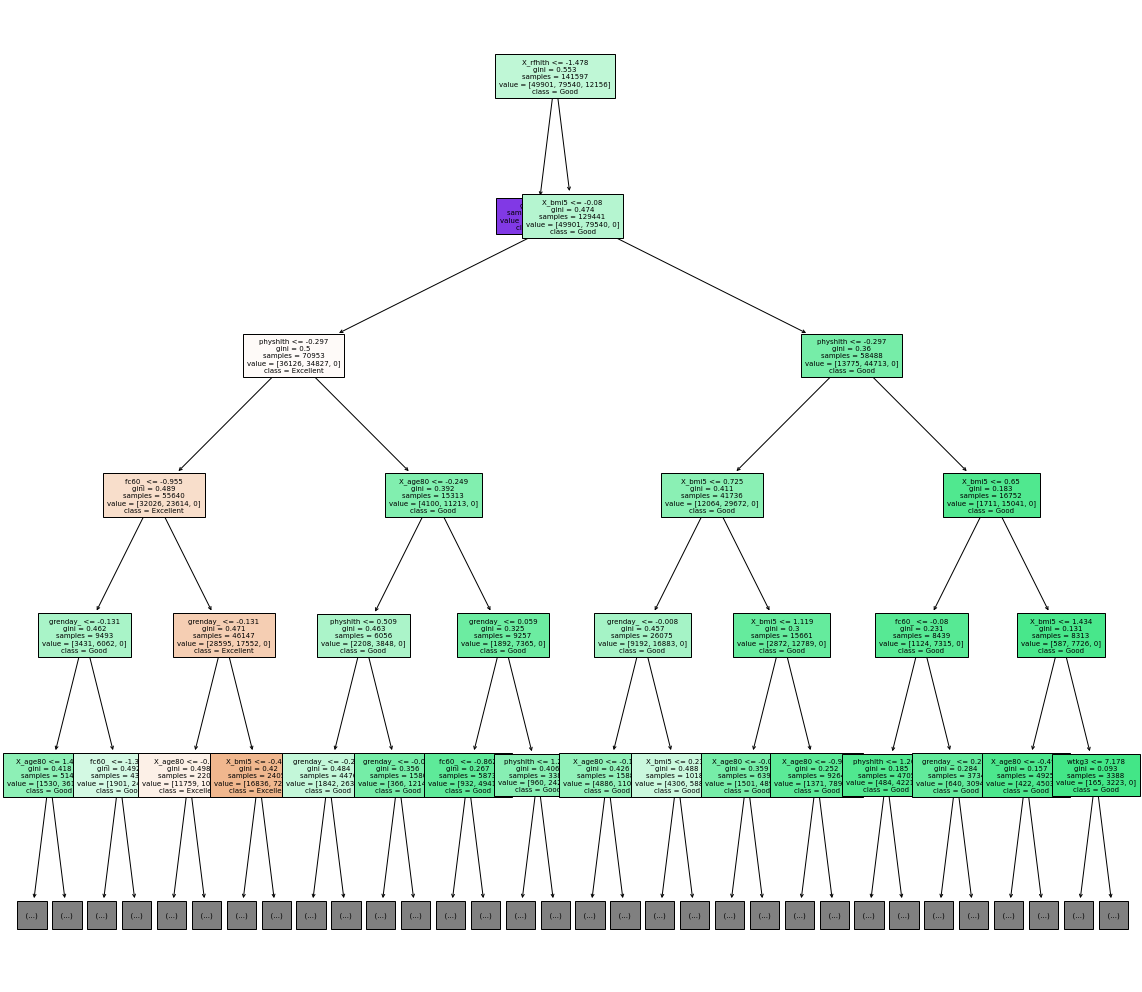

In [182]:
# Visualize decision tree
target_names = ['Excellent','Good','Poor']
fig = plt.figure(figsize=(20,18))
_ = plot_tree(clf,max_depth=5,
              feature_names=feature_imp.index[:10],
              class_names=target_names,
              filled=True,fontsize=7)
fig.savefig("/Users/aliceqichaowu/Desktop/decision_tree.png")


In [152]:
X_train.shape

(141597, 10)

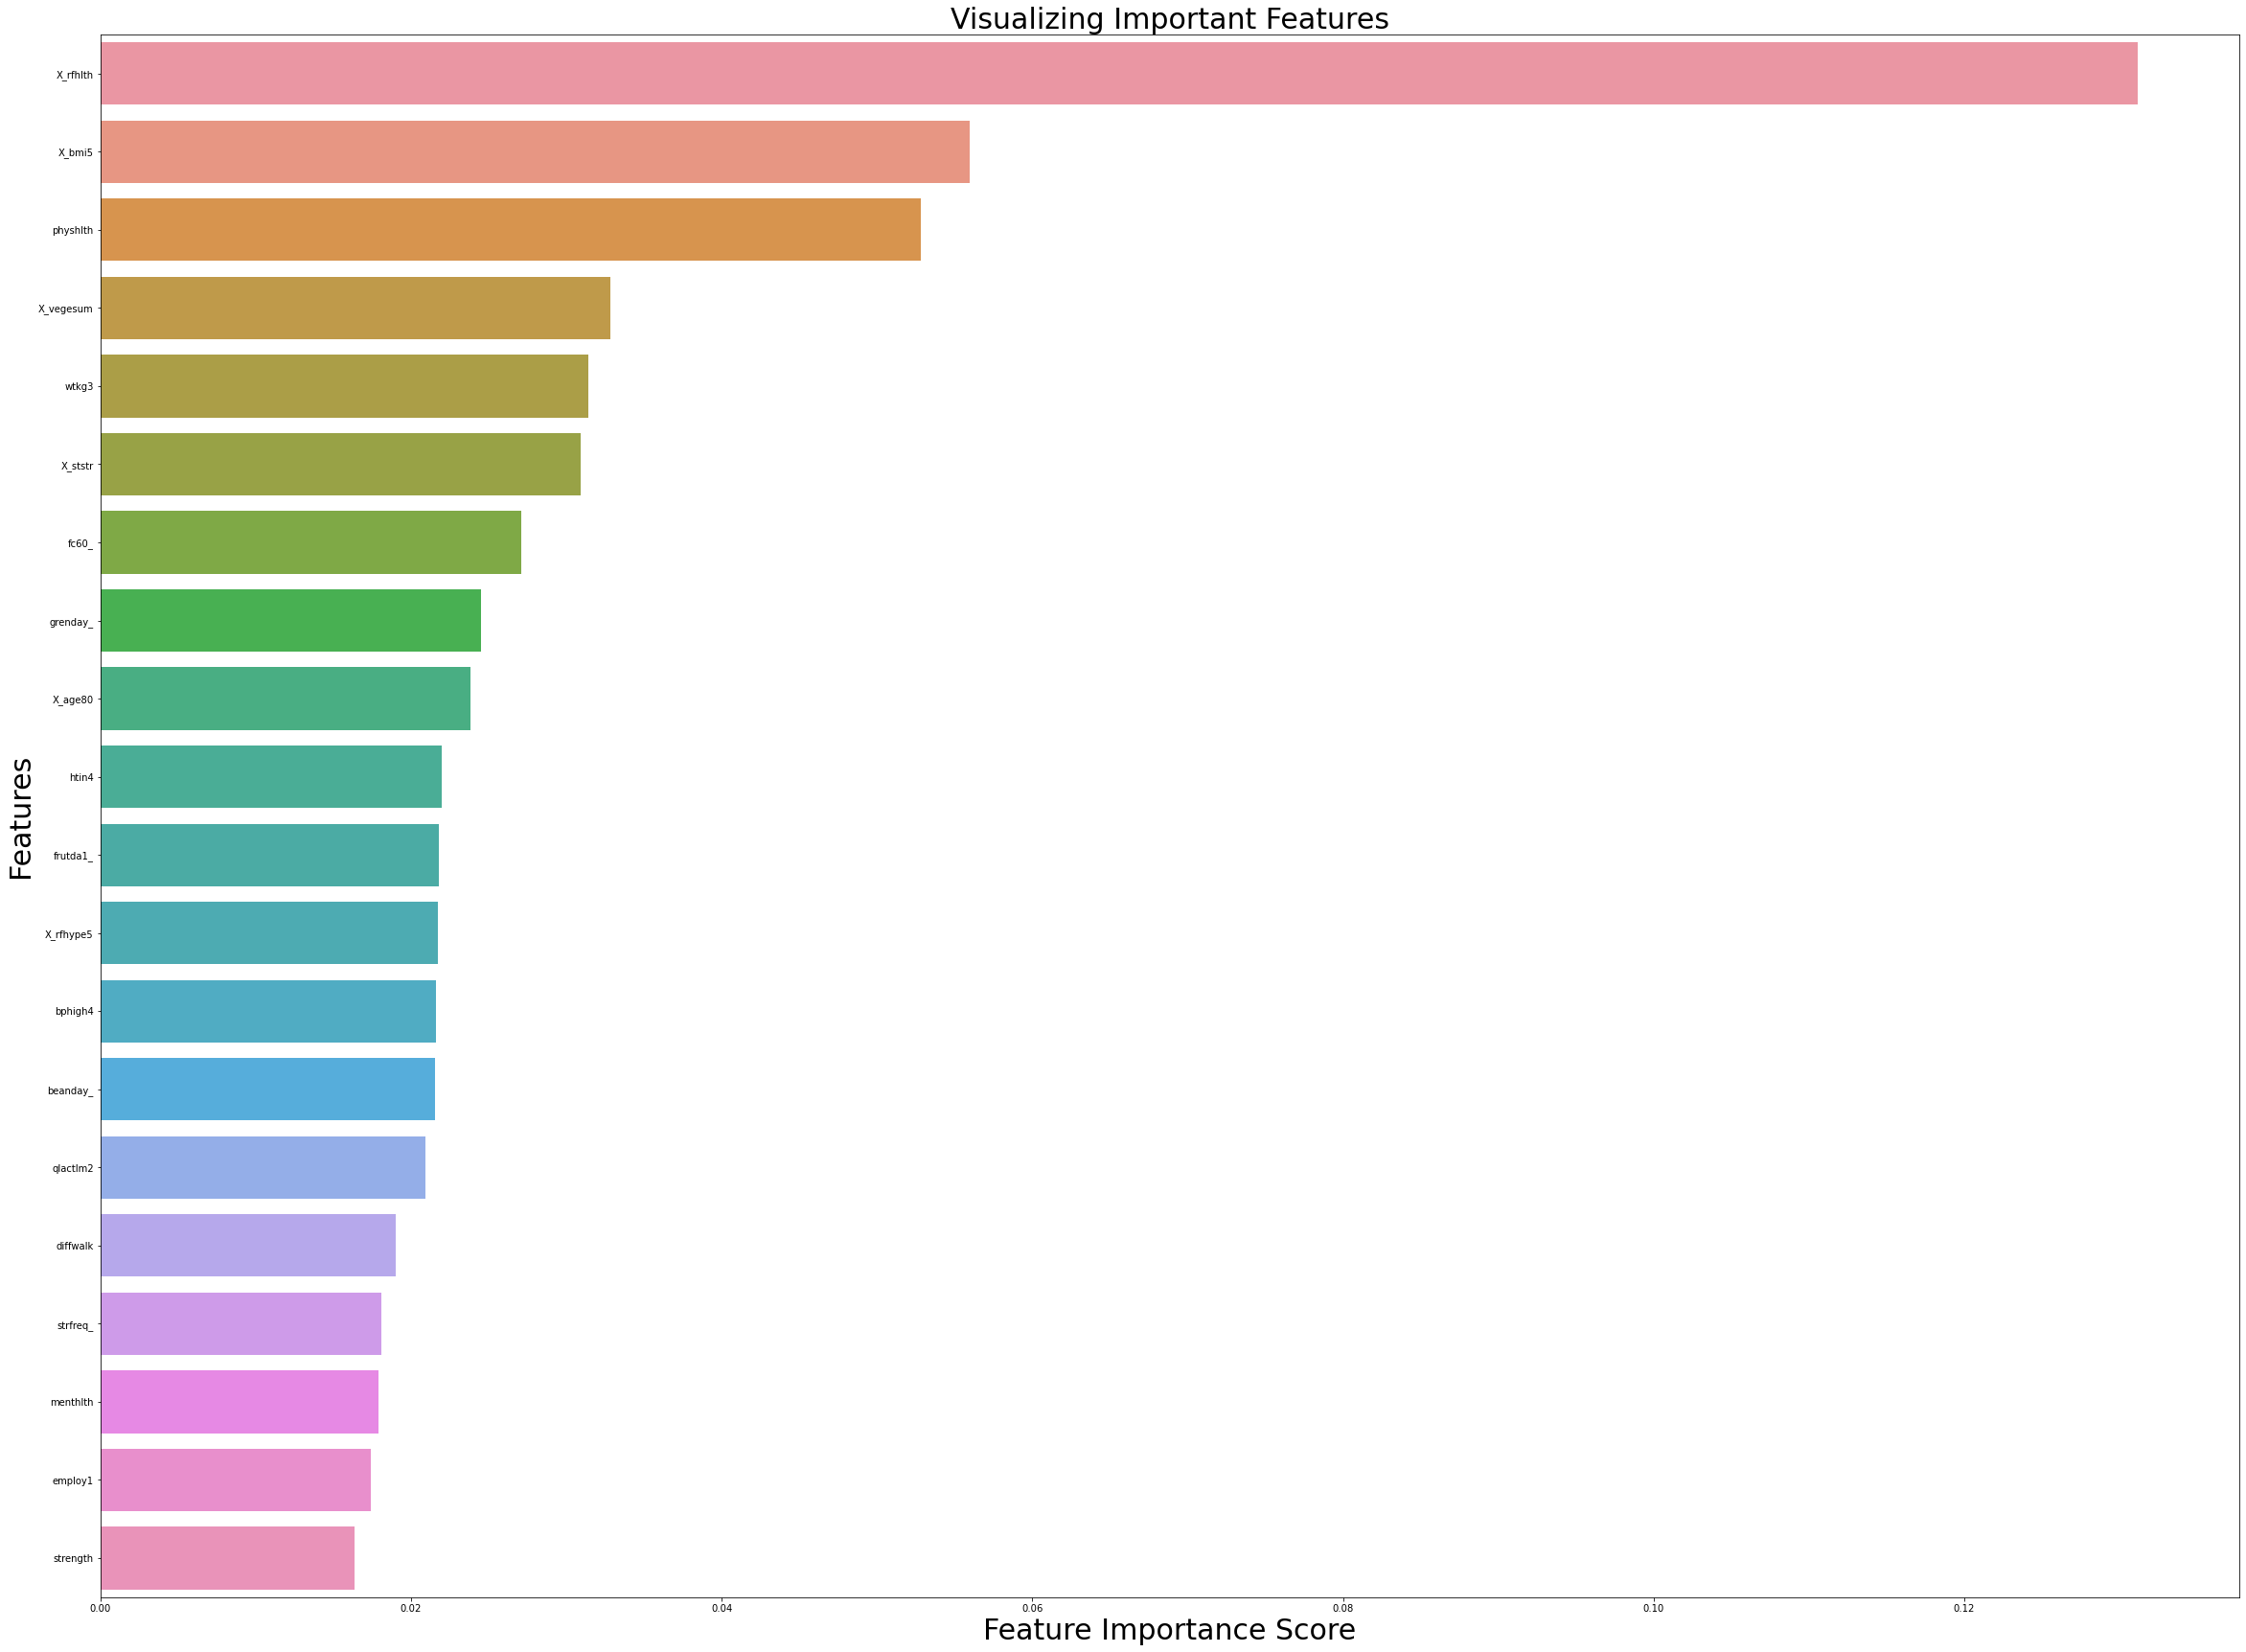

In [128]:
# feature_imp = pd.Series(rf.feature_importances_,index=X.columns.values).sort_values(ascending=False)
# # Creating a bar plot

# Add labels to your graph
fig, ax = plt.subplots(figsize=(40, 30))
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
ax.set_xlabel('Feature Importance Score',size=30)
ax.set_ylabel('Features',size=30)
ax.set_title("Visualizing Important Features",size=30)
fig.savefig("/Users/aliceqichaowu/Desktop/feature_imp.png")
# ax.legend()
plt.show()

## Evaluation

In [6]:
# Evaluation metrics
target_names = ['Excellent','Good','Poor']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

## Deal with imbalanced classes


### Method 1: SMOTE - Synthetic Minority Over-sampling Technique

In [5]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

- PCA + Histogram

In [ ]:
pca_sklearn = PCA()
projected = pca_sklearn.fit_transform(X_res)

figure = plt.figure(dpi=100)
plt.scatter(projected[:, 0], projected[:, 1],c=y_res, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('coolwarm', 5))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

In [ ]:
plt.hist(y_res,bins=[0,2,4,6],rwidth=0.5, color = 'orange')
plt.xticks([1,3,5],['Excellent','Good','Poor'])
plt.ylabel('Counts')
plt.title('Histogram of general health status')
plt.show()

### Method 2: Sample Class Weighting

In [143]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
def BalancedSampleWeights(y_train,class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in              
                        zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] *  class_weight_coef
    sample_weights = [class_weight_dict[i] for i in y_train]
    return sample_weights

#Usage
weight=BalancedSampleWeights(y,class_weight)
model = XGBClassifier(booster='gblinear',sample_weight = weight)
model.fit(X_train, y_train)

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=0         3
1         3
2         2
3         3
4         2
         ..
339277    3
339278    3
339279    4
339280    4
339281    2
Name: genhlth, Length: 333985, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-143-1ef6f1dfb185>:9: RuntimeWarning: divide by zero encountered in true_divide
  weights = total_samples / (n_classes * class_samples * 1.0)
/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifi

[19:33:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { sample_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:33:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=8, num_parallel_tree=None,...
                             inf, 0.4757865075701888, 1.3918129386074578,
                             array([0.95497352, 0.50932901, 0.60009102, 1.48993443, 3.89466914]),
                             array([0.95497352, 0.50932901, 0.60009102, 1.48993443, 3.89466914]),
                             0.5605712712783277, inf, inf, 0.5605712712783277,
                             0.4757865075701888, 0.4757865075701888, ...],
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=1, verbosity=None)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=0)
scaler = StandardScaler()  # normalization: zero mean, unit variance
scaler.fit(X_train)  # scaling factor determined from the training set

X_train = scaler.transform(X_train)
scaler.fit(X_test) 
X_test = scaler.transform(X_test)

In [180]:
## xgboost
mdl_xgb = XGBClassifier()#booster='gblinear'
mdl_xgb.fit(X_train, y_train)
y_pred_xgb_samp = np.squeeze(mdl_xgb.predict(X_test))
y_prob_xgb = mdl_xgb.predict_proba(X_test)


/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Best Model: Oversampling+XGBoost with hyperparameter tuning

In [24]:

params = {
#         learning_rate': [0.01, 0.1],
        'max_depth': [ 7, 10],
        'colsample_bytree': [0.5,1],
        'n_estimators' : [100, 200],
    }
gsearch = GridSearchCV(estimator =mdl_xgb,param_grid=params,n_jobs = -1, cv=5)
gsearch.fit(X_train,y_train)
print("Best R2 Score by grid search: ",gsearch.best_score_)
print("Best Parameters: ", gsearch.best_params_)
print("Best Estimators: ",gsearch.best_estimator_)

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best R2 Score by grid search:  0.8032797486485187
Best Parameters:  {'colsample_bytree': 0.5, 'max_depth': 7, 'n_estimators': 100}
Best Estimators:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0

In [25]:
gsearch.best_score_

0.8032797486485187

In [4]:
target_names = ['Excellent','Very good','Good','Fair','Poor']
print(classification_report(y_test, y_pred_xgb_samp, target_names=target_names))

## Model Evaluation

In [30]:
# Calculate ROC_AUC
roc=roc_auc_score(
    y_test, y_prob_xgb, multi_class="ovr", average="weighted")
print('The ROC score is: ', roc)


The ROC score is:  0.8919134007678394


In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(XGBClassifier(use_label_encoder=False), X, y, train_sizes=np.linspace(0.1, 1, 10), cv=5)

Accuracy: 0.805


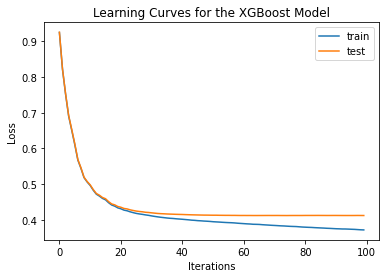

In [105]:
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
# mdl_xgb.fit(X_train, y_train, eval_metric='mlogloss', eval_set=evalset)
# evaluate performance
yhat = rf.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = mdl_xgb.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.title('Learning Curves for the XGBoost Model')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [136]:
target_names = ['Excellent','Good','Poor']
multi_classification_report(y_test, y_pred_rf, target_names,encoded_labels=True, as_frame=True)


,Excellent,Good,Poor
TP,7849.000000,16300.000000,3144.0
TN,19444.000000,10993.000000,32256.0
FP,3459.000000,4648.000000,0.0
FN,4648.000000,3459.000000,0.0
TPR,0.628071,0.824941,1.0
Recall,0.628071,0.824941,1.0
Sensitivity,0.628071,0.824941,1.0
TNR,0.848972,0.702832,1.0
Specificity,0.848972,0.702832,1.0
FPR,0.151028,0.297168,0.0


In [168]:
## Oversampling
multi_classification_report(y_test, y_pred_xgb_samp, target_names,encoded_labels=True, as_frame=True)

,Excellent,Very good,Good,Fair,Poor
TP,16585.000000,9134.000000,13582.000000,17903.000000,18668.000000
TN,81822.000000,83226.000000,85121.000000,88725.000000,87960.000000
FP,11774.000000,10227.000000,8755.000000,4756.000000,5610.000000
FN,6813.000000,14407.000000,9536.000000,5610.000000,4756.000000
TPR,0.708821,0.388004,0.587508,0.761409,0.796960
Recall,0.708821,0.388004,0.587508,0.761409,0.796960
Sensitivity,0.708821,0.388004,0.587508,0.761409,0.796960
TNR,0.874204,0.890565,0.906739,0.949123,0.940045
Specificity,0.874204,0.890565,0.906739,0.949123,0.940045
FPR,0.125796,0.109435,0.093261,0.050877,0.059955


In [14]:
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR)
             }
    return report

def multi_classification_report(y_true, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_true (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame
        
    Return:
        report (dict)
    """
    
    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix
    
    conf_labels = None if encoded_labels else labels
    
    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels
        
    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)
    
    if as_frame:
        return pd.DataFrame(report)
    return report